
# Vocal separation

This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

<div class="alert alert-danger"><h4>Warning</h4><p>This example is primarily of historical interest, and we do not recommend
    this as a competitive method for vocal source separation.
    For a more recent treatment of vocal and music source separation, please
    refer to [Open Source Tools & Data for Music Source Separation](https://source-separation.github.io/tutorial/landing.html) [1]_.</p></div>

This is based on the "REPET-SIM" method of [Rafii and Pardo, 2012](https://zenodo.org/record/1417631)
[2]_, but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by [Fitzgerald, 2012](https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1086&context=argcon) [3]_,
      but is a bit more numerically stable in practice.

.. [1] Manilow, Ethan, Prem Seetharaman, and Justin Salamon.
    "Open source tools & data for music source separation."
    2020.

.. [2] Rafii, Zafar, and Bryan Pardo.
    "Music/Voice Separation Using the Similarity Matrix."
    In ISMIR, pp. 583-588. 2012.

.. [3] FitzGerald, Derry.
    "Vocal separation using nearest neighbours and median filtering."
    23rd IET Irish Signals and Systems Conference, Maynooth.  (2012): 98-98.


In [ ]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import librosa
import os
from scipy.io.wavfile import write



Load an example with vocals.



In [ ]:
y, sr = librosa.load('/content/Kid CuDi Day N Nite.wav', duration=120)


# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))


Audio(data=y[1*sr:20*sr], rate=sr)

Plot a 5-second slice of the spectrum



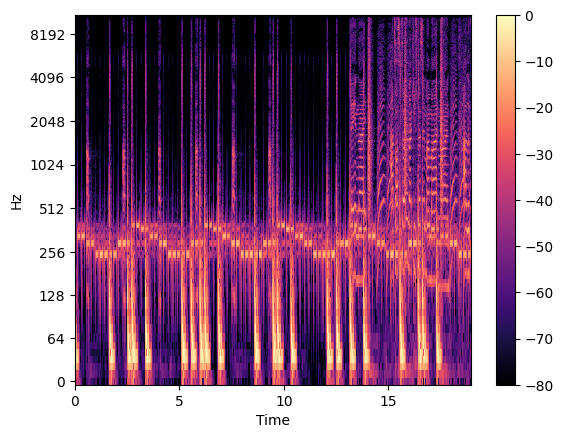

In [ ]:
idx = slice(*librosa.time_to_frames([1, 20], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.




In [ ]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [ ]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Plot the same slice, but separated into its foreground and background



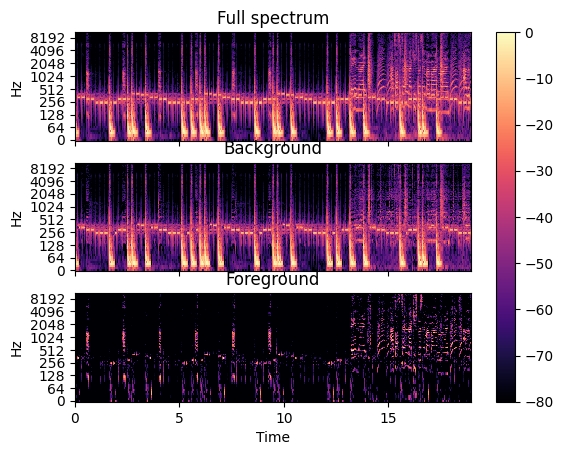

In [ ]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

Recover the foreground audio from the masked spectrogram.
To do this, we'll need to re-introduce the phase information
that we had previously set aside.



In [ ]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_foreground[1*sr:20*sr], rate=sr)

Next we save the output in a folder.

In [ ]:
y_foreground = librosa.istft(S_foreground * phase)
y_background = librosa.istft(S_background * phase)

output_dir = '/content/separated_audio'
os.makedirs(output_dir, exist_ok=True)

# Save the separated vocals and background as wav files
vocal_output_path = os.path.join(output_dir, 'vocals.wav')
background_output_path = os.path.join(output_dir, 'background.wav')

wavfile.write(vocal_output_path, sr, (y_foreground * 32767).astype(np.int16))
wavfile.write(background_output_path, sr, (y_background * 32767).astype(np.int16))

print(f"Vocals saved to {vocal_output_path}")
print(f"Background saved to {background_output_path}")

# Play back a 5-second excerpt with vocals
Audio(data=y_background[1*sr:20*sr], rate=sr)

Vocals saved to /content/separated_audio/vocals.wav
Background saved to /content/separated_audio/background.wav
